In [1]:
import numpy as np
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline  
import math
import random

### Géneration de  jeux de données 





In [216]:
# Fonction de normalisation des données 
def normalisation(dff) :
    df = dff.copy()
    for i in df.columns :
        mi = min(df[i])
        ma = max(df[i])
        df[i] =  (df[i]- mi) / (ma - mi)
    
    return df

def createGaussianDataFrame(center,sigma,nb_points):
    return pd.DataFrame(np.random.multivariate_normal(center,sigma,nb_points))
def createXOR(nb_points,var) :
    G1 = createGaussianDataFrame(np.array([1,1]),np.array([[var,0],[0,var]]),nb_points)
    G2 = createGaussianDataFrame(np.array([0,0]),np.array([[var,0],[0,var]]),nb_points)
    G3 = createGaussianDataFrame(np.array([0,1]),np.array([[var,0],[0,var]]),nb_points)
    G4 = createGaussianDataFrame(np.array([1,0]),np.array([[var,0],[0,var]]),nb_points)
    return G1.append(G2.append(G3.append(G4,ignore_index=True),ignore_index=True),ignore_index = True)
def createParal(nb_points,var1,var2) :
    G1 = createGaussianDataFrame(np.array([1,0.6]),np.array([[var1,var2],[var2,var1]]),nb_points)
    G2 = createGaussianDataFrame(np.array([1,0.4]),np.array([[var1,var2],[var2,var1]]),nb_points)
    return G1.append(G2,ignore_index = True)

### ALGORITHME K-MEANS :

In [107]:
# fonction de caclcul de deux points données 
# prend une fonction de calcul de distance en paramétre 
def distance(fdist,x1,x2):
    return fdist(x1,x2)


# fonction de caclcul de distance euclidienne entre deux points 
def euclidienne(x1,x2):
    return math.sqrt(pow(x2.values-x1.values,2).sum())


# fonction de caclcul de distance de mannathan entre deux points 
def mannathan(x1,x2):
    return abs(x2.values-x1.values).sum()


# fonction de calcul d'un centroide 
def centroide(df) :
    return pd.DataFrame(np.mean(df)).T


# Fonction inertie_cluster qui, étant donné une chaîne de caractères donnant le nom de la distance à utiliser,
# et un DataFrame contenant un ensemble d'exemples, rend la valeur de l'inertie de cet ensemble.
def inertie_cluster(fdist,df) :
    inertieCluster = 0
    centroide_ = centroide(df)
    for i,ligne in df.iterrows() :
        inertieCluster += pow(distance(fdist,centroide_,pd.DataFrame(ligne).T),2)
    return inertieCluster


# Fonction choix_depart() qui étant donné un entier K>1 et une base d'apprentissage (sous la forme d'un DataFrame)
# de n exemples rend ensemble de centroides contenant K exemples tirés aléatoirement dans la base.
def choix_depart(k,df) :
    v = [i for i in range(0,len(df))]
    random.shuffle(v)
    return pd.DataFrame(df.iloc [v[0:k]])

# Fonction plus_proche() qui, étant donné une fonction de distance à utiliser,
# un exemple et un ensemble de centroides,
# rend l'indice (dans l'ensemble) du centroide dont l'exemple est le plus proche. En cas d'égalité de distance, 
# le centroide de plus petit indice est choisi.

def plus_proche(fdist,x,centroides):
    distanceMinimum = -1
    indiceMin = 0
    for i,ligne in centroides.iterrows():
        distance_ = distance(fdist,x,pd.DataFrame(ligne).T)
        if (distanceMinimum > distance_ or distanceMinimum < 0) :
            distanceMinimum = distance_
            indiceMin = i
    return indiceMin


# Fonction affecte_cluster() qui, étant donné un nom de distance,
# une base d'apprentissage et un ensemble de centroïdes,
# rend la matrice d'affectation des exemples de la base aux clusters représentés par chaque centroïde.
def affecte_cluster(fdist, base, centroides):
    d = {}
    for i , c in centroides.iterrows():
        d[i]=[]
    for j,x in base.iterrows():
            centroideProche = plus_proche(fdist,pd.DataFrame(x).T,centroides)
            d[centroideProche].append(j)
    return d

#Fonction nouveaux_centroides() qui, étant donné un chaîne de caractères donnant le nom d'une distance,
# une base d'apprentissage et une matrice d'affectation, rend l'ensemble des centroides correspondant.
def nouveaux_centroides(fdist,base,dic):
    new_centroides = pd.DataFrame()
    c = []
    for i in dic.keys():
        c = dic[i]
        new_centroides = new_centroides.append(centroide(pd.DataFrame(base.iloc[c[0:]])),ignore_index=True) 
    return new_centroides

# Fonction inertie_cluster(), écrire la fonction inertie_globale() qui,
# étant donné un nom de distance, une base d'apprentissage et une matrice d'affectation,
# rend la valeur de l'inertie globale du partitionnement correspondant.
def inertie_globale(fdist,base,dicAffectation):
    inertieGlobale = 0
    for i in dicAffectation.keys():
        ine = inertie_cluster(fdist,pd.DataFrame(dicAffectation[i]))
        inertieGlobale += ine
    return inertieGlobale


#############################  Algorithme des K-moyennes  ###################################################
#    Fonction kmoyennes() qui prend en argument un entier K>1, une base d'apprentissage, un nom de distance,#
#    ainsi que deux nombres: un réel epsilon>0 et un entier iter_max>1,                                     #
#    et qui rend un ensemble de centroides et une matrice d'affectation.                                    #
#############################################################################################################

def kmoyennes(k,base,fdist,epsilon,iter_max) :
    
    #variables
    iter = 0
    new_centroides = {}
    dict_affectation = {}
    
    # initialisation 
    clusters_init = choix_depart(k,base)
    dict_affectation = affecte_cluster(fdist,base,clusters_init)
    
    #Boucle
    convergence = 1
    while(convergence > epsilon and iter < iter_max ) :
        new_centroides = nouveaux_centroides(fdist,base,dict_affectation)
        convergence = inertie_globale(fdist,base,dict_affectation)
        dict_affectation = affecte_cluster(fdist,base,new_centroides)
        convergence = abs(convergence - inertie_globale(fdist,base,dict_affectation))
        iter += 1
    
    return new_centroides,dict_affectation,iter,convergence
    

In [130]:
import matplotlib
import colorsys

def AffichagesClusters(centroides,dictAffectation,base):
    
    M_data2D = base.as_matrix()
    colonne_X= M_data2D[0:,0]
    colonne_Y= M_data2D[0:,1]
    #Nombre de couluers
    colorNbr = len(centroides)
    #Choix aléatoire des couleurs
    colorNames = list(matplotlib.colors.cnames.keys())
    colors = [i for i in range(len(colorNames))]
    random.shuffle(colors)
    colors =colors[0:colorNbr] 
    
    
    colorMap = [] 
    for i in range(colorNbr) :
        colorMap.append(colorNames[colors[i]])
    colorMap = np.array(colorMap)
    
    categories = np.zeros(len(base))
    categories = np.array(categories)
    for key,values in dictAffectation.items() :
        for indice in values :
            categories[indice] = int(key)
    categories = categories.astype(int)
    
    plt.scatter(colonne_X,colonne_Y,s=100,c=colorMap[categories.astype(int)])
    
    #Affichage des centroides finaux en noir 
    M_data2D = centroides.as_matrix()
    colonne_X= M_data2D[0:,0]
    colonne_Y= M_data2D[0:,1]
    plt.scatter(colonne_X,colonne_Y,color='black')
# Fonction d'affichage des résultats
def affichageResults(les_centres, l_affectation,nb_iter,convergence) :
    print("Le nombre d'itération : ",nb_iter)
    print("convergence : ", convergence)
    print("Les centres : \n",les_centres)
    print("Les affectations : \n")

    for c,v in l_affectation.items() :
        print("Cluster",c," : ",v)

    AffichagesClusters(les_centres, l_affectation,points)

In [209]:
points = createXOR(50,0.01)
les_centres, l_affectation,nb_iter,convergence = kmoyennes(4, points, euclidienne, 0.15,50)

Le nombre d'itération :  3
convergence :  0.0
Les centres : 
           0         1
0  0.011545 -0.005831
1  1.002239  0.022974
2  0.021674  0.984119
3  1.003169  1.005413
Les affectations : 

Cluster 0  :  [50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
Cluster 1  :  [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199]
Cluster 2  :  [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149]
Cluster 3  :  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1

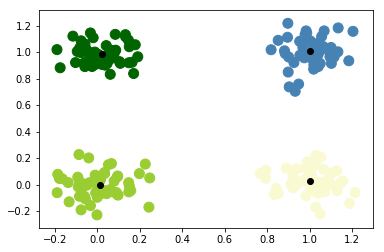

In [211]:
affichageResults(les_centres, l_affectation,nb_iter,convergence)

In [220]:
points = createParal(20,0.01,0.01)
les_centres, l_affectation,nb_iter,convergence = kmoyennes(2, points, euclidienne, 0.15,100)
    

Le nombre d'itération :  5
convergence :  0.0
Les centres : 
           0         1
0  0.916072  0.386660
1  1.060688  0.582428
Les affectations : 

Cluster 0  :  [0, 9, 10, 13, 15, 18, 20, 22, 23, 25, 26, 27, 31, 32, 35, 37, 39]
Cluster 1  :  [1, 2, 3, 4, 5, 6, 7, 8, 11, 12, 14, 16, 17, 19, 21, 24, 28, 29, 30, 33, 34, 36, 38]


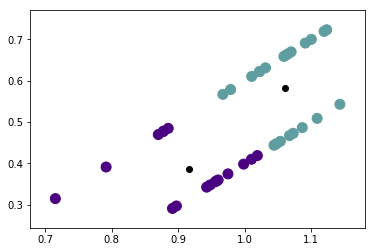

In [221]:

affichageResults(les_centres, l_affectation,nb_iter,convergence)